En este cuaderno, se realizará un desarrollo de un modelo muy similar al modelo 3, con DeepLabV3+, pero con algunas modificaciones. Se entrenará el modelo con imágenes de 256x256 en lugar de 128x128 y se utilizará un encoder resnet34. Esto hará que el entrenamiento sea muchísimo más lento, pero las predicciones serán más precisas (en el modelo 3 las predicciones aparecían más cuadriculadas debido a la resolución 128x128, en este modelo deberán aparecer más redondeadas). Otro dato importante es que voy a mantener el entrenamiento en 5 épocas porque no puedo entrenar el modelo con más épocas debido a la complejidad del algoritmo, podría estar en ejecución mucho tiempo.

In [ ]:
!pip install -U segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
#Paso 2: Imports y configuraciones
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

# Configuración general
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
IMG_DIM = 256
EPOCHS = 5

In [ ]:
#Paso 3: Dataset personalizado
class TumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Añadir canal
            mask = mask / 255.0

        return img.float(), mask.float()

In [ ]:
#Paso 4: Transformaciones al dataset
train_transform = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Rotate(limit=15),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
#Paso 5: preparar las rutas de imágenes y máscaras (identico al código de U-Net)

#https://drive.google.com/file/d/19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB/view?usp=drive_link
import os
import gdown

# Reemplaza con el ID de tu archivo compartido en Google Drive
file_id = "19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB"
output_file = "dataset.zip"

# Construir el enlace de descarga y descargar el archivo
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# Descomprimir el archivo en la carpeta 'dataset'
!unzip -o dataset.zip -d dataset

dataset_path = "dataset/lgg-mri-segmentation/kaggle_3m"
image_paths = []
mask_paths = []

for folder in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        files = sorted(os.listdir(folder_path))
        images = {f.replace('.tif', ''): os.path.join(folder_path, f)
                  for f in files if f.endswith('.tif') and '_mask' not in f}
        masks = {f.replace('_mask.tif', ''): os.path.join(folder_path, f)
                 for f in files if '_mask' in f}
        for key in images:
            if key in masks:
                image_paths.append(images[key])
                mask_paths.append(masks[key])


Downloading...
From (original): https://drive.google.com/uc?id=19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB
From (redirected): https://drive.google.com/uc?id=19lCs0VBMr1f1vlR7OwPPVz0LXzAn68kB&confirm=t&uuid=0b118164-90bc-4909-9835-2deb5b7f4de1
To: /content/dataset.zip
100%|██████████| 369M/369M [00:04<00:00, 82.1MB/s]


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_11_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif  
  inflating: dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_

In [ ]:
#Paso 6: Dividir en conjuntos de entrenamiento y validación

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

train_dataset = TumorDataset(train_images, train_masks, transform=train_transform)
val_dataset = TumorDataset(val_images, val_masks, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#Paso 7: Modelo de DeepLabV3+
#Decision del modelo --> encoder_name = mobilenet_v2, resnet sería mucho mejor pero la GPU de Google Colab tardaría muchísimo en entrenar el modelo
#Por esto mismo, también entrenamos el modelo en 5 épocas en lugar de en 25, porque podríamos estar días entrenando el modelo
#También he reducido el tamaño de las imagenes a 128, porque afecta a la duración de la ejecución
#Obviamente esto ocasionará perjuicios en la predicción del modelo pero no podemos hacer otra cosa ya que podría estar muchísimo tiempo para ejecutarse
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # puedes cambiar el backbone (mobilenet, resnet50, etc.)
    encoder_weights="imagenet",     # usa pesos preentrenados para mejorar
    in_channels=3,
    classes=1,                      # salida binaria
).to(DEVICE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
#Paso 8: Función de pérdida y optimizador
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
#Paso 9: Entrenamiento y evaluación del modelo
def train(model, loader, optimizer, criterion, epoch_num=None):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 5 == 0:
            print(f"  Epoch {epoch_num} - Batch {batch_idx+1}/{len(loader)} - Loss: {loss.item():.4f}")

    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    ious = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = torch.sigmoid(model(x)) > 0.5
            intersection = (preds & (y > 0.5)).float().sum((1,2,3))
            union = (preds | (y > 0.5)).float().sum((1,2,3))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.extend(iou.cpu().numpy())
    return np.mean(ious)


In [ ]:
#Paso 9: entrenamiento del modelo
for epoch in range(EPOCHS):
    loss = train(model, train_loader, optimizer, criterion, epoch+1)
    val_iou = evaluate(model, val_loader)
    print(f"📅 Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f} - Val IoU: {val_iou:.4f}")

  Epoch 1 - Batch 1/393 - Loss: 0.9882
  Epoch 1 - Batch 6/393 - Loss: 0.9707
  Epoch 1 - Batch 11/393 - Loss: 0.9503
  Epoch 1 - Batch 16/393 - Loss: 0.9368
  Epoch 1 - Batch 21/393 - Loss: 0.9923
  Epoch 1 - Batch 26/393 - Loss: 0.9201
  Epoch 1 - Batch 31/393 - Loss: 0.9517
  Epoch 1 - Batch 36/393 - Loss: 0.9601
  Epoch 1 - Batch 41/393 - Loss: 0.9929
  Epoch 1 - Batch 46/393 - Loss: 0.8976
  Epoch 1 - Batch 51/393 - Loss: 0.9219
  Epoch 1 - Batch 56/393 - Loss: 0.9159
  Epoch 1 - Batch 61/393 - Loss: 0.9019
  Epoch 1 - Batch 66/393 - Loss: 0.8575
  Epoch 1 - Batch 71/393 - Loss: 0.9888
  Epoch 1 - Batch 76/393 - Loss: 0.9104
  Epoch 1 - Batch 81/393 - Loss: 0.7377
  Epoch 1 - Batch 86/393 - Loss: 0.9113
  Epoch 1 - Batch 91/393 - Loss: 0.9209
  Epoch 1 - Batch 96/393 - Loss: 0.9356
  Epoch 1 - Batch 101/393 - Loss: 0.9006
  Epoch 1 - Batch 106/393 - Loss: 0.8679
  Epoch 1 - Batch 111/393 - Loss: 0.8850
  Epoch 1 - Batch 116/393 - Loss: 0.8161
  Epoch 1 - Batch 121/393 - Loss: 0.88

In [ ]:
torch.save(model.state_dict(), "modelo_deeplabv3_tumores_resnet256.pth")

from google.colab import files
files.download("modelo_deeplabv3_tumores_resnet256.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install gdown
#https://drive.google.com/file/d/12Z9uNExyyqJTBbJLTt0U7fu2cJ4q0EDi/view?usp=drive_link
import gdown

# ID del archivo compartido públicamente desde tu Google Drive
file_id = "12Z9uNExyyqJTBbJLTt0U7fu2cJ4q0EDi"  # <--- Reemplaza con tu ID real
output = "deeplab256_resnet.pth"

# Descargar el modelo directamente
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=12Z9uNExyyqJTBbJLTt0U7fu2cJ4q0EDi
From (redirected): https://drive.google.com/uc?id=12Z9uNExyyqJTBbJLTt0U7fu2cJ4q0EDi&confirm=t&uuid=c5f8034c-0747-4ef3-9e57-eed6e54bc460
To: /content/deeplab256_resnet.pth
100%|██████████| 89.9M/89.9M [00:00<00:00, 95.3MB/s]


'deeplab256_resnet.pth'

In [ ]:
import segmentation_models_pytorch as smp
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Construir el modelo igual que al entrenarlo
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1
).to(DEVICE)

# Cargar los pesos
model.load_state_dict(torch.load("deeplab256_resnet.pth", map_location=DEVICE))
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_DIM = 256  # Igual al usado en entrenamiento

def preprocess_image_gradio(img_pil):
    img = np.array(img_pil)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.Normalize(),
        ToTensorV2()
    ])
    augmented = transform(image=img)
    img_tensor = augmented['image'].unsqueeze(0).to(DEVICE)

    return img_tensor, img

def predict_image(model, img_pil):
    original_size = img_pil.size  # (width, height)

    # Preprocesar imagen
    img_tensor, img_rgb = preprocess_image_gradio(img_pil)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))
        pred_mask = (pred > 0.5).float().cpu().squeeze().numpy()

    # Redimensionar la máscara predicha al tamaño original
    pred_mask_resized = cv2.resize(pred_mask, original_size, interpolation=cv2.INTER_NEAREST)

    # Superponer en rojo
    mask_colored = np.zeros_like(img_rgb)
    mask_colored[:, :, 0] = (pred_mask_resized * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_rgb, 0.8, mask_colored, 0.5, 0)
    return Image.fromarray(img_rgb), Image.fromarray(overlay)

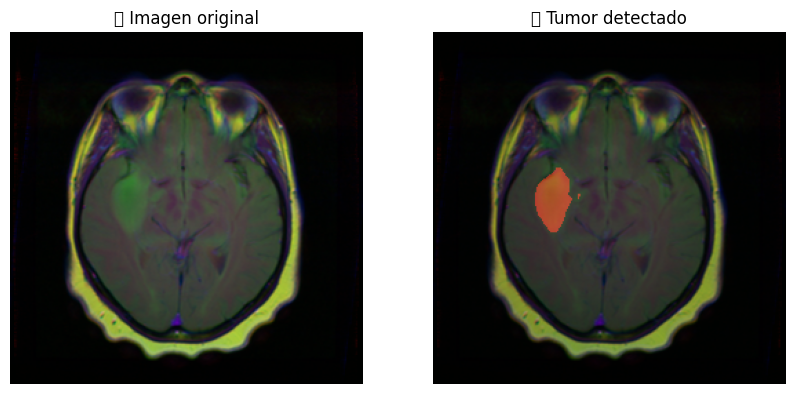

In [ ]:
original, overlay = predict_image(model, Image.open("TCGA_CS_4942_19970222_9.tif"))

# Mostrar resultado
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("🧠 Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("🔍 Tumor detectado")
plt.axis("off")

plt.show()